# CNN sa generatorom i augmentacijom podataka

In [47]:
import os
import cv2
import glob
import fnmatch
import numpy as np
import pandas as pd
from sklearn import model_selection
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import imblearn
import random
import seaborn as sns # Paket za crtanje countplotova(vizuelno predstavljanje klasa kod nebalansiranosti)

In [3]:
from keras import utils
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D
from keras.optimizers import Adam

In [116]:
def plot(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    
    epochs = history.epoch
    loss = history.history['loss']
    validation_loss = history.history['val_loss']
    plt.title('LOSS')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.plot(epochs,loss,c='red',label='training')
    plt.plot(epochs,validation_loss,c='blue',label='validation')
    plt.legend(loc='best')
    
    plt.subplot(1, 2, 2)
    
    acc = history.history['f1_m']
    acc_val = history.history['val_f1_m']
    plt.title('F1')
    plt.xlabel('epochs')
    plt.ylabel('f1')
    plt.plot(epochs,acc,c='red',label='training')
    plt.plot(epochs,acc_val,c='blue',label='validation')
    plt.legend(loc='best')
    
    plt.show()

### Učitavanje podataka

In [7]:
imagePatches = glob.glob('C:/Users/pc/Desktop/data/**/*.png', recursive=True)

In [8]:
imagePatches = imagePatches[:40000]

In [ ]:
len(imagePatches)

In [10]:
patternZero = '*class0.png'
patternOne = '*class1.png'

In [11]:
classZero = fnmatch.filter(imagePatches, patternZero) 
classOne = fnmatch.filter(imagePatches, patternOne)

In [12]:
print('IDC(-):{}, IDC(+):{}'.format(len(classZero), len(classOne)))

IDC(-):30753, IDC(+):9247


In [13]:
labels = np.zeros(len(imagePatches))
for i in range(len(imagePatches)):
    if imagePatches[i] in classZero:
        labels[i] = 1
    else:
        labels[i] = 0

In [14]:
train_val_paths, test_paths, labels_train_val, labels_test = model_selection.train_test_split(imagePatches, labels, test_size = 0.33, random_state = 42, stratify=labels)

In [15]:
print('train_validation_size:{}, test_size:{}'.format(len(train_val_paths), len(test_paths)))

train_validation_size:26800, test_size:13200


In [36]:
classZeroTrainVal = fnmatch.filter(train_val_paths, patternZero) 
classOneTrainVal = fnmatch.filter(train_val_paths, patternOne)
print('TrainVal skup: IDC(-):{}, IDC(+):{}'.format(len(classZeroTrainVal), len(classOneTrainVal)))

TrainVal skup: IDC(-):20605, IDC(+):6195


In [27]:
classZeroTest = fnmatch.filter(test_paths, patternZero) 
classOneTest = fnmatch.filter(test_paths, patternOne)
print('Test skup:  IDC(-):{}, IDC(+):{}'.format(len(classZeroTest), len(classOneTest)))

Test skup:  IDC(-):10148, IDC(+):3052


In [30]:
# učitavamo sike test skupa jer će biti potrebne za predviđanje
width = 50
height = 50
X_test = []
y_test = []
for i in range(len(test_paths)):
    X_test.append(cv2.resize(cv2.imread(test_paths[i]), (width, height), interpolation=cv2.INTER_CUBIC))
    if test_paths[i] in classOneTest:
        y_test.append(1)
    else:
        y_test.append(0)

In [31]:
X_test = np.array(X_test)
X_test = X_test/255

In [32]:
X_test.shape

(13200, 50, 50, 3)

### Podela podataka na train,validacioni i test skup

In [33]:
train_paths, val_paths = model_selection.train_test_split(train_val_paths, test_size = 0.2, random_state = 42, stratify=labels_train_val)

In [37]:
classZeroTrain = fnmatch.filter(train_paths, patternZero) 
classOneTrain = fnmatch.filter(train_paths, patternOne)
print('Train skup:  IDC(-):{}, IDC(+):{}'.format(len(classZeroTrain), len(classOneTrain)))

Train skup:  IDC(-):16484, IDC(+):4956


In [39]:
classZeroVal = fnmatch.filter(val_paths, patternZero) 
classOneVal = fnmatch.filter(val_paths, patternOne)
print('Val skup:  IDC(-):{}, IDC(+):{}'.format(len(classZeroVal), len(classOneVal)))

Val skup:  IDC(-):4121, IDC(+):1239


### Kreiranje generatora

In [99]:
def generator(paths, batch_size, width, height, n_classes):
    
    patternZero = '*class0.png'
    patternOne = '*class1.png'
    classZero = fnmatch.filter(paths, patternZero) 
    classOne = fnmatch.filter(paths, patternOne)
    
    
    while True:

    
        # mesacemo indekse da bi nam se batch-evi medjusobno razlikovali
        # ovde bi trebalo funkcija koja bira bez ponavljanja, ja sam pokusala sample i choise ali nisu radile
        indices = np.random.randint(0, len(paths)-1, size = batch_size) 
        X = []
        y = [] 
        
        for i in indices:
            X.append(cv2.resize(cv2.imread(paths[i]), (width, height), interpolation=cv2.INTER_CUBIC))
            if paths[i] in classOne:
                y.append(1)
            else:
                y.append(0)
 
        
        numZero = len(classZero)
        numOne = len(classOne)
        if(paths=='train_paths'):
            if(numZero!=numOne):
                n = numZero-numOne
                index = np.random.randint(0, numOne, size=n)
                pathOne = classOne[index]
                for j in range(n):
                    img = cv2.resize(cv2.imread(pathOne[j]), (width, height), interpolation=cv2.INTER_CUBIC)
                    img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
                    img = cv2.flip(img, -1)
                    X.append(img)
                    y.append(1)
        # ovo je pod komentarom jer je prijavljivalo gresku a nisam mogla da resim                   
        #index = np.arange(2*numZero)
        #index = np.random.shuffle(index)           
        #X = X[index]
        #y = y[index]
        

        
        X = np.array(X)
        y = np.array(y)  
        
        X = X.astype('float32')
        X = X/255
        
        yield X, utils.to_categorical(y, num_classes = n_classes)

### Kreiranje i treniranje mreže 

In [100]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [101]:
width = 50
height = 50
batch_size = 64
n_classes = 2

In [102]:
train_gen = generator(train_paths, batch_size = batch_size, width = width, height = height, n_classes = n_classes)
val_gen = generator(val_paths, batch_size = batch_size, width = width, height = height, n_classes = n_classes)
test_gen = generator(test_paths, batch_size = batch_size, width = width, height = height, n_classes = n_classes)

In [103]:
input_shape = (50,50,3)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', input_shape=input_shape))
model.add(Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=[f1_m])

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 50, 50, 32)        896       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 50, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 25, 25, 64)        0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 40000)             0         
_________________________________________________________________
dense_17 (Dense)             (None, 128)               5120128   
_________________________________________________________________
dropout_18 (Dropout)         (None, 128)              

In [104]:
epochs = 25
steps_per_epoch = len(train_paths)//batch_size
val_steps = len(val_paths)//batch_size
test_steps = len(test_paths)//batch_size

In [106]:
history = model.fit_generator(train_gen, epochs = epochs, steps_per_epoch = steps_per_epoch, validation_data=val_gen, validation_steps=val_steps)

Epoch 1/25
335/335 [==============================] - 217s 646ms/step - loss: 0.3523 - f1_m: 0.8490 - val_loss: 0.4404 - val_f1_m: 0.8532
Epoch 2/25
335/335 [==============================] - 219s 655ms/step - loss: 0.3380 - f1_m: 0.8528 - val_loss: 0.3149 - val_f1_m: 0.8577
Epoch 3/25
335/335 [==============================] - 237s 708ms/step - loss: 0.3363 - f1_m: 0.8564 - val_loss: 0.4481 - val_f1_m: 0.8485
Epoch 4/25
335/335 [==============================] - 231s 689ms/step - loss: 0.3225 - f1_m: 0.8593 - val_loss: 0.2526 - val_f1_m: 0.8520
Epoch 5/25
335/335 [==============================] - 231s 691ms/step - loss: 0.3063 - f1_m: 0.8687 - val_loss: 0.1884 - val_f1_m: 0.8586
Epoch 6/25
335/335 [==============================] - 240s 715ms/step - loss: 0.2861 - f1_m: 0.8752 - val_loss: 0.3170 - val_f1_m: 0.8567
Epoch 7/25
335/335 [==============================] - 249s 743ms/step - loss: 0.2714 - f1_m: 0.8836 - val_loss: 0.3543 - val_f1_m: 0.8464
Epoch 8/25
335/335 [==============

### Evaluacija mreže 

In [107]:
model.metrics_names

['loss', 'f1_m']

In [109]:
score_train = model.evaluate_generator(train_gen, steps = steps_per_epoch, verbose = 0) 

In [111]:
print('loss_train:{:.2f}, f1_score_train: {:.2f}' .format(score_train[0],score_train[1]))

loss_train:0.04, f1_score_train: 0.99


In [112]:
score_test = model.evaluate_generator(test_gen, steps = test_steps, verbose = 0)

In [113]:
print('loss_test:{:.2f}, f1_score_test: {:.2f}' .format(score_test[0],score_test[0]))

loss_test:0.54, f1_score_test: 0.54


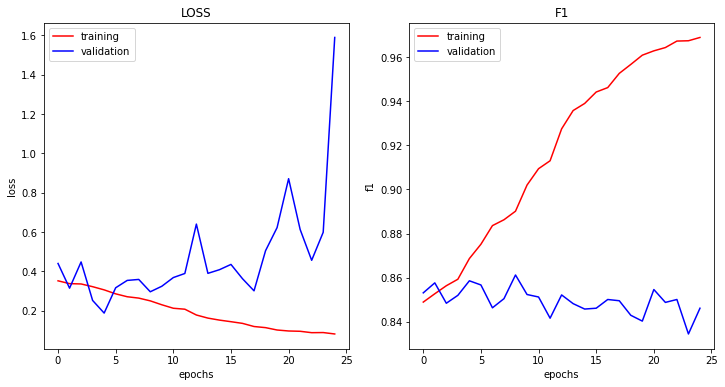

In [117]:
plot(history)

In [ ]:
# mislim da se ovde model preprilagodjava podacima, posto greska na validaionom skupu stalno raste 
# a F1 se ne povecava
# ovo je mozda i posledica sto nisam mogla da izmesam slike, pa je veliki broj slika 1 klase na kraju 
# train skupa 
# a i zbog funkcije randint mogao je da pokupi vise istih slika 
# tako da mislim da bi ovo definitivo trebalo da se sredi i mozda da se trenira sa learning rate = 0.01
# i sa 20 epoha
# a i matrica konfuzije kaze da  se prilagodjava klasi 0

In [118]:
y_pred = model.predict(X_test)

In [119]:
y_pred = np.argmax(y_pred, axis = 1)

In [120]:
m = confusion_matrix(y_test,y_pred)
print(m) 

[[9516  632]
 [1329 1723]]


In [121]:
r = classification_report(y_test,y_pred)
print(r)

              precision    recall  f1-score   support

           0       0.88      0.94      0.91     10148
           1       0.73      0.56      0.64      3052

    accuracy                           0.85     13200
   macro avg       0.80      0.75      0.77     13200
weighted avg       0.84      0.85      0.84     13200



In [125]:
accuracy = metrics.accuracy_score(y_test,y_pred)
print('auc_score modela: {:.2f}' .format(accuracy))

auc_score modela: 0.85


In [126]:
f1 = metrics.f1_score(y_test,y_pred)
print('auc_score modela: {:.2f}' .format(f1))

auc_score modela: 0.64


In [122]:
auc_score = metrics.roc_auc_score(y_test,y_pred)
print('auc_score modela: {:.2f}' .format(auc_score))

auc_score modela: 0.75


### Čuvanje modela

In [127]:
model.save('models/cnn.h5')